# Neural Network for CLA Project

## Import statements

In [1]:
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import Constants
import copy

## Hyperparameters

In [2]:
# data processing
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
batch_size = 96    # batch size for the DataLoaders. previously was 100

# NN model
num_features = 13
input_size = num_features     # size of input layer
multiplier = 100         # multiplied by num_features to determine the size of each hidden layer. previously was 100
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.001         # learning rate of optimizer. previously was 0.01
num_epochs = 100                # number of epochs

# training the model
use_previous_best_model = False

## Read in data

In [3]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
data_path_hourly = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"
# data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
# data_set_hourly = "hourly_data_2017"
# data_set = "all_data_summer"
# data_path = "../Data/data/"
X_2015 = np.load(data_path_hourly + 'hourly_X_2015.npy')
X_2016 = np.load(data_path_hourly + 'hourly_X_2016.npy')
X_2017 = np.load(data_path_hourly + 'hourly_X_2017.npy')
X_2018 = np.load(data_path_hourly + 'hourly_X_2018.npy')  # WHAT IS THE FIRST COLUMN??? WHERE IS THE ''??????

y_2015 = np.load(data_path_hourly + 'hourly_y_2015.npy')
y_2016 = np.load(data_path_hourly + 'hourly_y_2016.npy')
y_2017 = np.load(data_path_hourly + 'hourly_y_2017.npy')
y_2018 = np.load(data_path_hourly + 'hourly_y_2018.npy')

X = np.vstack((X_2015, X_2016, X_2017, X_2018))
y = np.hstack((y_2015, y_2016, y_2017, y_2018))
# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
# idx = 0
# sample_bias = 0
# length_y = len(y)
# while num_alg != (num_no_alg + sample_bias):
#     # circle through the data sets until the difference of num_no_alg and num_alg equals
#     # the value specified by sample_bias
#     if idx == (length_y - 1):
#         idx = 0

#     if y[idx] == 1:
#         if np.random.rand() >= 0.5:  # add this sample with some probability
#             y = np.append(y, y[idx])
#             X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
#             num_alg += 1
#         else:
#             idx += 1
#     else:
#         idx += 1

### Process and split data set

In [4]:
# standardize data: remove the mean and variance in each sample
num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y)
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)

# convert numpy arrays to pytorch tensors
train_set_size = X_train.shape
test_set_size = X_test.shape
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=test_set_size[0], shuffle=True)

/Users/Alliot/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype <U100 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/Alliot/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype <U100 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Define neural network model

In [5]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, output_size)     # previously, this was output_size
#         self.tanh6 = nn.Tanh()                             # previously, this was the line which was commented out
#         self.fc7 = nn.Linear(hidden_size, output_size)
#         self.relu7 = nn.ReLU()
#         self.fc8 = nn.Linear(hidden_size, hidden_size)
#         self.relu8 = nn.ReLU()
#         self.fc9 = nn.Linear(hidden_size, output_size)
#         self.relu9 = nn.ReLU()
#         self.fc10 = nn.Linear(hidden_size, hidden_size)
#         self.relu10 = nn.ReLU()
#         self.fc11 = nn.Linear(hidden_size, hidden_size)
#         self.relu11 = nn.ReLU()
#         self.fc12 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.tanh4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
#         out = self.tanh6(out)
#         out = self.fc7(out)
#         out = self.relu7(out)
#         out = self.fc8(out)
#         out = self.relu8(out)
#         out = self.fc9(out)
#         out = self.relu9(out)
#         out = self.fc10(out)
#         out = self.relu10(out)
#         out = self.fc11(out)
#         out = self.relu11(out)
#         out = self.fc12(out)
        out = self.sig1(out)
        return out

### Instantiate the neural network

In [6]:
model = CLANet(input_size, hidden_size, output_size)
criterion = nn.BCELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=1, dampening=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
model.double();     # cast model parameters to double

## Train the neural network

In [7]:
model.train()     # training mode
if not use_previous_best_model:
    avg_error = 0
    best_avg_error = 1

avg_error_vec = []

for epoch in range(num_epochs):
    print("Epoch: %d/%d" % (epoch+1, num_epochs))

    for i, (samples, labels) in enumerate(train_loader):
        samples = Variable(samples)
        labels = Variable(labels)
        output = model(samples)                # forward pass
        output = torch.flatten(output)         # resize predicted labels
        labels = labels.type(torch.DoubleTensor)
        
        loss = criterion(output, labels)  # calculate loss
        optimizer.zero_grad()     # clear gradient
        loss.backward()           # calculate gradients
        optimizer.step()          # update weights
        
        # calculate and print error
        out = output

        for j in range(0, out.size()[0]):
            if out[j] < 0.5:
                out[j] = 0
            else:
                out[j] = 1
        error = 1 - torch.sum(output == labels).item() / labels.size()[0]
        avg_error += error

        print("  Iteration: %d/%d, Loss: %g, Error: %0.4f" % 
              (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), loss.item(), error))
    
    avg_error = avg_error / np.ceil(X_train.size()[0] / batch_size)
    avg_error_vec.append(avg_error)
    print("Average Error for this Epoch: %0.4f" % avg_error)

    if avg_error < best_avg_error:
        print("found a better model!")
        best_avg_error = avg_error
        best_model = copy.deepcopy(model)
        use_previous_best_model = True
    
    avg_error = 0

Epoch: 1/100
  Iteration: 1/35, Loss: 0.691201, Error: 0.3229
  Iteration: 2/35, Loss: 0.641502, Error: 0.2708
  Iteration: 3/35, Loss: 0.842457, Error: 0.7812
  Iteration: 4/35, Loss: 0.668202, Error: 0.3229
  Iteration: 5/35, Loss: 0.643493, Error: 0.3229
  Iteration: 6/35, Loss: 0.661187, Error: 0.3125
  Iteration: 7/35, Loss: 0.554163, Error: 0.2396
  Iteration: 8/35, Loss: 0.518997, Error: 0.2083
  Iteration: 9/35, Loss: 0.612928, Error: 0.2812
  Iteration: 10/35, Loss: 0.609014, Error: 0.2917
  Iteration: 11/35, Loss: 0.560078, Error: 0.1771
  Iteration: 12/35, Loss: 0.643872, Error: 0.3229
  Iteration: 13/35, Loss: 0.484322, Error: 0.1875
  Iteration: 14/35, Loss: 0.595428, Error: 0.2604
  Iteration: 15/35, Loss: 0.575631, Error: 0.2604
  Iteration: 16/35, Loss: 0.562487, Error: 0.2500
  Iteration: 17/35, Loss: 0.647038, Error: 0.3438
  Iteration: 18/35, Loss: 0.561655, Error: 0.1979
  Iteration: 19/35, Loss: 0.591695, Error: 0.2708
  Iteration: 20/35, Loss: 0.491457, Error: 0.1

  Iteration: 21/35, Loss: 0.445633, Error: 0.1667
  Iteration: 22/35, Loss: 0.603219, Error: 0.2812
  Iteration: 23/35, Loss: 0.661158, Error: 0.3333
  Iteration: 24/35, Loss: 0.536153, Error: 0.2292
  Iteration: 25/35, Loss: 0.489218, Error: 0.1979
  Iteration: 26/35, Loss: 0.582709, Error: 0.2604
  Iteration: 27/35, Loss: 0.563678, Error: 0.2604
  Iteration: 28/35, Loss: 0.661656, Error: 0.3438
  Iteration: 29/35, Loss: 0.544322, Error: 0.2188
  Iteration: 30/35, Loss: 0.543223, Error: 0.2396
  Iteration: 31/35, Loss: 0.566812, Error: 0.2604
  Iteration: 32/35, Loss: 0.47861, Error: 0.1771
  Iteration: 33/35, Loss: 0.622612, Error: 0.3229
  Iteration: 34/35, Loss: 0.597996, Error: 0.2708
  Iteration: 35/35, Loss: 0.668794, Error: 0.4000
Average Error for this Epoch: 0.2632
Epoch: 6/100
  Iteration: 1/35, Loss: 0.477985, Error: 0.1667
  Iteration: 2/35, Loss: 0.514566, Error: 0.2188
  Iteration: 3/35, Loss: 0.601133, Error: 0.2917
  Iteration: 4/35, Loss: 0.577875, Error: 0.2708
  Ite

  Iteration: 7/35, Loss: 0.633713, Error: 0.2917
  Iteration: 8/35, Loss: 0.533011, Error: 0.2083
  Iteration: 9/35, Loss: 0.565918, Error: 0.2604
  Iteration: 10/35, Loss: 0.526718, Error: 0.2188
  Iteration: 11/35, Loss: 0.578347, Error: 0.2812
  Iteration: 12/35, Loss: 0.609703, Error: 0.3229
  Iteration: 13/35, Loss: 0.599637, Error: 0.3021
  Iteration: 14/35, Loss: 0.585098, Error: 0.2917
  Iteration: 15/35, Loss: 0.578598, Error: 0.2812
  Iteration: 16/35, Loss: 0.585524, Error: 0.2812
  Iteration: 17/35, Loss: 0.514193, Error: 0.2292
  Iteration: 18/35, Loss: 0.621122, Error: 0.2917
  Iteration: 19/35, Loss: 0.562516, Error: 0.2604
  Iteration: 20/35, Loss: 0.535583, Error: 0.2500
  Iteration: 21/35, Loss: 0.589282, Error: 0.2917
  Iteration: 22/35, Loss: 0.522223, Error: 0.2396
  Iteration: 23/35, Loss: 0.596643, Error: 0.2604
  Iteration: 24/35, Loss: 0.553198, Error: 0.2396
  Iteration: 25/35, Loss: 0.522893, Error: 0.2292
  Iteration: 26/35, Loss: 0.540367, Error: 0.2188
  I

  Iteration: 28/35, Loss: 0.57713, Error: 0.2500
  Iteration: 29/35, Loss: 0.659063, Error: 0.3438
  Iteration: 30/35, Loss: 0.581916, Error: 0.2812
  Iteration: 31/35, Loss: 0.600284, Error: 0.3125
  Iteration: 32/35, Loss: 0.566639, Error: 0.2500
  Iteration: 33/35, Loss: 0.54074, Error: 0.2396
  Iteration: 34/35, Loss: 0.569219, Error: 0.2604
  Iteration: 35/35, Loss: 0.528312, Error: 0.2000
Average Error for this Epoch: 0.2587
Epoch: 15/100
  Iteration: 1/35, Loss: 0.5647, Error: 0.2708
  Iteration: 2/35, Loss: 0.495414, Error: 0.1875
  Iteration: 3/35, Loss: 0.581292, Error: 0.2812
  Iteration: 4/35, Loss: 0.575975, Error: 0.2604
  Iteration: 5/35, Loss: 0.515543, Error: 0.2188
  Iteration: 6/35, Loss: 0.642189, Error: 0.3125
  Iteration: 7/35, Loss: 0.609506, Error: 0.3125
  Iteration: 8/35, Loss: 0.549837, Error: 0.2500
  Iteration: 9/35, Loss: 0.567983, Error: 0.2604
  Iteration: 10/35, Loss: 0.603113, Error: 0.3021
  Iteration: 11/35, Loss: 0.62204, Error: 0.3229
  Iteration: 

  Iteration: 14/35, Loss: 0.522998, Error: 0.2396
  Iteration: 15/35, Loss: 0.508862, Error: 0.2083
  Iteration: 16/35, Loss: 0.578523, Error: 0.2917
  Iteration: 17/35, Loss: 0.561974, Error: 0.2708
  Iteration: 18/35, Loss: 0.577543, Error: 0.2604
  Iteration: 19/35, Loss: 0.575004, Error: 0.2812
  Iteration: 20/35, Loss: 0.559404, Error: 0.2812
  Iteration: 21/35, Loss: 0.587131, Error: 0.2812
  Iteration: 22/35, Loss: 0.545533, Error: 0.2500
  Iteration: 23/35, Loss: 0.476711, Error: 0.1562
  Iteration: 24/35, Loss: 0.478104, Error: 0.2188
  Iteration: 25/35, Loss: 0.694155, Error: 0.3125
  Iteration: 26/35, Loss: 0.634303, Error: 0.2917
  Iteration: 27/35, Loss: 0.552753, Error: 0.2708
  Iteration: 28/35, Loss: 0.564522, Error: 0.2604
  Iteration: 29/35, Loss: 0.534936, Error: 0.2396
  Iteration: 30/35, Loss: 0.570302, Error: 0.2812
  Iteration: 31/35, Loss: 0.520821, Error: 0.1979
  Iteration: 32/35, Loss: 0.599989, Error: 0.2917
  Iteration: 33/35, Loss: 0.591749, Error: 0.3021


  Iteration: 35/35, Loss: 0.569982, Error: 0.2500
Average Error for this Epoch: 0.2583
Epoch: 24/100
  Iteration: 1/35, Loss: 0.549988, Error: 0.2500
  Iteration: 2/35, Loss: 0.588244, Error: 0.2917
  Iteration: 3/35, Loss: 0.580523, Error: 0.2812
  Iteration: 4/35, Loss: 0.556789, Error: 0.2708
  Iteration: 5/35, Loss: 0.528922, Error: 0.2500
  Iteration: 6/35, Loss: 0.533257, Error: 0.2708
  Iteration: 7/35, Loss: 0.541495, Error: 0.2500
  Iteration: 8/35, Loss: 0.568463, Error: 0.2812
  Iteration: 9/35, Loss: 0.490846, Error: 0.2188
  Iteration: 10/35, Loss: 0.492756, Error: 0.1771
  Iteration: 11/35, Loss: 0.710539, Error: 0.3750
  Iteration: 12/35, Loss: 0.638271, Error: 0.3229
  Iteration: 13/35, Loss: 0.578159, Error: 0.3021
  Iteration: 14/35, Loss: 0.620938, Error: 0.3438
  Iteration: 15/35, Loss: 0.621212, Error: 0.3646
  Iteration: 16/35, Loss: 0.59135, Error: 0.3125
  Iteration: 17/35, Loss: 0.593321, Error: 0.2812
  Iteration: 18/35, Loss: 0.56875, Error: 0.2500
  Iteratio

  Iteration: 20/35, Loss: 0.591853, Error: 0.3229
  Iteration: 21/35, Loss: 0.559085, Error: 0.2500
  Iteration: 22/35, Loss: 0.59757, Error: 0.2708
  Iteration: 23/35, Loss: 0.573509, Error: 0.2500
  Iteration: 24/35, Loss: 0.576088, Error: 0.2604
  Iteration: 25/35, Loss: 0.58165, Error: 0.2812
  Iteration: 26/35, Loss: 0.516302, Error: 0.2500
  Iteration: 27/35, Loss: 0.629109, Error: 0.2917
  Iteration: 28/35, Loss: 0.525375, Error: 0.2292
  Iteration: 29/35, Loss: 0.598528, Error: 0.2917
  Iteration: 30/35, Loss: 0.503433, Error: 0.2083
  Iteration: 31/35, Loss: 0.505415, Error: 0.2292
  Iteration: 32/35, Loss: 0.554203, Error: 0.2396
  Iteration: 33/35, Loss: 0.562173, Error: 0.2396
  Iteration: 34/35, Loss: 0.666643, Error: 0.3438
  Iteration: 35/35, Loss: 0.537122, Error: 0.2500
Average Error for this Epoch: 0.2601
Epoch: 29/100
  Iteration: 1/35, Loss: 0.63162, Error: 0.3438
  Iteration: 2/35, Loss: 0.601077, Error: 0.3125
  Iteration: 3/35, Loss: 0.595687, Error: 0.3125
  Ite

  Iteration: 5/35, Loss: 0.549823, Error: 0.2708
  Iteration: 6/35, Loss: 0.593777, Error: 0.2708
  Iteration: 7/35, Loss: 0.54216, Error: 0.2396
  Iteration: 8/35, Loss: 0.635806, Error: 0.3229
  Iteration: 9/35, Loss: 0.573724, Error: 0.2812
  Iteration: 10/35, Loss: 0.596158, Error: 0.2812
  Iteration: 11/35, Loss: 0.517583, Error: 0.2292
  Iteration: 12/35, Loss: 0.623605, Error: 0.3333
  Iteration: 13/35, Loss: 0.554886, Error: 0.2708
  Iteration: 14/35, Loss: 0.576642, Error: 0.2500
  Iteration: 15/35, Loss: 0.555396, Error: 0.2500
  Iteration: 16/35, Loss: 0.562022, Error: 0.2708
  Iteration: 17/35, Loss: 0.487917, Error: 0.1875
  Iteration: 18/35, Loss: 0.557723, Error: 0.2708
  Iteration: 19/35, Loss: 0.590591, Error: 0.2812
  Iteration: 20/35, Loss: 0.453362, Error: 0.1979
  Iteration: 21/35, Loss: 0.535001, Error: 0.2292
  Iteration: 22/35, Loss: 0.686754, Error: 0.3542
  Iteration: 23/35, Loss: 0.511408, Error: 0.2188
  Iteration: 24/35, Loss: 0.538566, Error: 0.2604
  Iter

  Iteration: 26/35, Loss: 0.643158, Error: 0.3333
  Iteration: 27/35, Loss: 0.526633, Error: 0.2500
  Iteration: 28/35, Loss: 0.556179, Error: 0.2396
  Iteration: 29/35, Loss: 0.557488, Error: 0.2500
  Iteration: 30/35, Loss: 0.617942, Error: 0.3229
  Iteration: 31/35, Loss: 0.601749, Error: 0.3125
  Iteration: 32/35, Loss: 0.632541, Error: 0.3333
  Iteration: 33/35, Loss: 0.587543, Error: 0.2604
  Iteration: 34/35, Loss: 0.548304, Error: 0.2500
  Iteration: 35/35, Loss: 0.503259, Error: 0.2000
Average Error for this Epoch: 0.2569
Epoch: 38/100
  Iteration: 1/35, Loss: 0.510259, Error: 0.1979
  Iteration: 2/35, Loss: 0.595318, Error: 0.2812
  Iteration: 3/35, Loss: 0.465599, Error: 0.1875
  Iteration: 4/35, Loss: 0.557418, Error: 0.2708
  Iteration: 5/35, Loss: 0.559827, Error: 0.2396
  Iteration: 6/35, Loss: 0.5551, Error: 0.2396
  Iteration: 7/35, Loss: 0.59534, Error: 0.2812
  Iteration: 8/35, Loss: 0.524749, Error: 0.2188
  Iteration: 9/35, Loss: 0.555665, Error: 0.2500
  Iteration

  Iteration: 11/35, Loss: 0.666797, Error: 0.3021
  Iteration: 12/35, Loss: 0.580229, Error: 0.2917
  Iteration: 13/35, Loss: 0.520051, Error: 0.2292
  Iteration: 14/35, Loss: 0.53976, Error: 0.2500
  Iteration: 15/35, Loss: 0.601153, Error: 0.2917
  Iteration: 16/35, Loss: 0.530495, Error: 0.2500
  Iteration: 17/35, Loss: 0.59182, Error: 0.2917
  Iteration: 18/35, Loss: 0.457286, Error: 0.1562
  Iteration: 19/35, Loss: 0.518105, Error: 0.2083
  Iteration: 20/35, Loss: 0.558, Error: 0.2396
  Iteration: 21/35, Loss: 0.571528, Error: 0.3125
  Iteration: 22/35, Loss: 0.530563, Error: 0.2396
  Iteration: 23/35, Loss: 0.600704, Error: 0.2917
  Iteration: 24/35, Loss: 0.587569, Error: 0.2708
  Iteration: 25/35, Loss: 0.607959, Error: 0.3125
  Iteration: 26/35, Loss: 0.600107, Error: 0.3229
  Iteration: 27/35, Loss: 0.637014, Error: 0.3229
  Iteration: 28/35, Loss: 0.557438, Error: 0.2500
  Iteration: 29/35, Loss: 0.574236, Error: 0.2917
  Iteration: 30/35, Loss: 0.539974, Error: 0.1979
  Ite

  Iteration: 32/35, Loss: 0.526964, Error: 0.2292
  Iteration: 33/35, Loss: 0.673562, Error: 0.2708
  Iteration: 34/35, Loss: 0.578097, Error: 0.2708
  Iteration: 35/35, Loss: 0.506894, Error: 0.2500
Average Error for this Epoch: 0.2601
Epoch: 47/100
  Iteration: 1/35, Loss: 0.543446, Error: 0.2708
  Iteration: 2/35, Loss: 0.592499, Error: 0.2917
  Iteration: 3/35, Loss: 0.557923, Error: 0.2708
  Iteration: 4/35, Loss: 0.579767, Error: 0.2812
  Iteration: 5/35, Loss: 0.563177, Error: 0.2708
  Iteration: 6/35, Loss: 0.506941, Error: 0.2083
  Iteration: 7/35, Loss: 0.495975, Error: 0.1979
  Iteration: 8/35, Loss: 0.516813, Error: 0.2396
  Iteration: 9/35, Loss: 0.756399, Error: 0.3438
  Iteration: 10/35, Loss: 0.567432, Error: 0.2604
  Iteration: 11/35, Loss: 0.603177, Error: 0.2917
  Iteration: 12/35, Loss: 0.607632, Error: 0.2708
  Iteration: 13/35, Loss: 0.53893, Error: 0.2708
  Iteration: 14/35, Loss: 0.612767, Error: 0.2917
  Iteration: 15/35, Loss: 0.603894, Error: 0.3125
  Iterati

  Iteration: 17/35, Loss: 0.486466, Error: 0.2083
  Iteration: 18/35, Loss: 0.565432, Error: 0.2812
  Iteration: 19/35, Loss: 0.592439, Error: 0.2604
  Iteration: 20/35, Loss: 0.492855, Error: 0.2083
  Iteration: 21/35, Loss: 0.511718, Error: 0.2188
  Iteration: 22/35, Loss: 0.563374, Error: 0.2604
  Iteration: 23/35, Loss: 0.517604, Error: 0.2188
  Iteration: 24/35, Loss: 0.615959, Error: 0.3229
  Iteration: 25/35, Loss: 0.562799, Error: 0.2604
  Iteration: 26/35, Loss: 0.518509, Error: 0.2500
  Iteration: 27/35, Loss: 0.521492, Error: 0.2188
  Iteration: 28/35, Loss: 0.516756, Error: 0.2396
  Iteration: 29/35, Loss: 0.528549, Error: 0.2500
  Iteration: 30/35, Loss: 0.716653, Error: 0.3750
  Iteration: 31/35, Loss: 0.494466, Error: 0.2292
  Iteration: 32/35, Loss: 0.582262, Error: 0.2812
  Iteration: 33/35, Loss: 0.539077, Error: 0.2396
  Iteration: 34/35, Loss: 0.518976, Error: 0.2083
  Iteration: 35/35, Loss: 0.450858, Error: 0.1500
Average Error for this Epoch: 0.2543
Epoch: 52/100

  Iteration: 2/35, Loss: 0.525608, Error: 0.2396
  Iteration: 3/35, Loss: 0.579814, Error: 0.2500
  Iteration: 4/35, Loss: 0.574117, Error: 0.2604
  Iteration: 5/35, Loss: 0.483673, Error: 0.2083
  Iteration: 6/35, Loss: 0.689714, Error: 0.3125
  Iteration: 7/35, Loss: 0.524121, Error: 0.2188
  Iteration: 8/35, Loss: 0.511975, Error: 0.2188
  Iteration: 9/35, Loss: 0.557202, Error: 0.2604
  Iteration: 10/35, Loss: 0.530231, Error: 0.2292
  Iteration: 11/35, Loss: 0.539812, Error: 0.2500
  Iteration: 12/35, Loss: 0.527198, Error: 0.2292
  Iteration: 13/35, Loss: 0.588114, Error: 0.2917
  Iteration: 14/35, Loss: 0.593118, Error: 0.2917
  Iteration: 15/35, Loss: 0.577545, Error: 0.2604
  Iteration: 16/35, Loss: 0.665035, Error: 0.3646
  Iteration: 17/35, Loss: 0.498636, Error: 0.2188
  Iteration: 18/35, Loss: 0.59386, Error: 0.2917
  Iteration: 19/35, Loss: 0.570355, Error: 0.2917
  Iteration: 20/35, Loss: 0.5634, Error: 0.2917
  Iteration: 21/35, Loss: 0.587247, Error: 0.2812
  Iteration

  Iteration: 23/35, Loss: 0.577587, Error: 0.2812
  Iteration: 24/35, Loss: 0.568727, Error: 0.2708
  Iteration: 25/35, Loss: 0.669554, Error: 0.3646
  Iteration: 26/35, Loss: 0.537163, Error: 0.2500
  Iteration: 27/35, Loss: 0.520682, Error: 0.2292
  Iteration: 28/35, Loss: 0.555063, Error: 0.2500
  Iteration: 29/35, Loss: 0.493498, Error: 0.2083
  Iteration: 30/35, Loss: 0.544029, Error: 0.2604
  Iteration: 31/35, Loss: 0.548641, Error: 0.2188
  Iteration: 32/35, Loss: 0.529068, Error: 0.2396
  Iteration: 33/35, Loss: 0.594188, Error: 0.2917
  Iteration: 34/35, Loss: 0.528746, Error: 0.2396
  Iteration: 35/35, Loss: 0.550859, Error: 0.2500
Average Error for this Epoch: 0.2560
Epoch: 61/100
  Iteration: 1/35, Loss: 0.563378, Error: 0.2917
  Iteration: 2/35, Loss: 0.462591, Error: 0.1979
  Iteration: 3/35, Loss: 0.54313, Error: 0.2604
  Iteration: 4/35, Loss: 0.531984, Error: 0.2604
  Iteration: 5/35, Loss: 0.543579, Error: 0.2396
  Iteration: 6/35, Loss: 0.57998, Error: 0.2812
  Itera

  Iteration: 8/35, Loss: 0.595083, Error: 0.3125
  Iteration: 9/35, Loss: 0.548947, Error: 0.2604
  Iteration: 10/35, Loss: 0.494819, Error: 0.2396
  Iteration: 11/35, Loss: 0.595079, Error: 0.2812
  Iteration: 12/35, Loss: 0.604477, Error: 0.3125
  Iteration: 13/35, Loss: 0.502862, Error: 0.2396
  Iteration: 14/35, Loss: 0.549482, Error: 0.2604
  Iteration: 15/35, Loss: 0.519479, Error: 0.1979
  Iteration: 16/35, Loss: 0.553357, Error: 0.2604
  Iteration: 17/35, Loss: 0.510129, Error: 0.2292
  Iteration: 18/35, Loss: 0.502644, Error: 0.2396
  Iteration: 19/35, Loss: 0.585564, Error: 0.2604
  Iteration: 20/35, Loss: 0.543138, Error: 0.2604
  Iteration: 21/35, Loss: 0.521488, Error: 0.2292
  Iteration: 22/35, Loss: 0.492719, Error: 0.2292
  Iteration: 23/35, Loss: 0.505126, Error: 0.2188
  Iteration: 24/35, Loss: 0.569655, Error: 0.2604
  Iteration: 25/35, Loss: 0.529357, Error: 0.2292
  Iteration: 26/35, Loss: 0.681955, Error: 0.3750
  Iteration: 27/35, Loss: 0.56362, Error: 0.2604
  I

  Iteration: 30/35, Loss: 0.576348, Error: 0.2604
  Iteration: 31/35, Loss: 0.595683, Error: 0.2604
  Iteration: 32/35, Loss: 0.539106, Error: 0.2500
  Iteration: 33/35, Loss: 0.553698, Error: 0.2604
  Iteration: 34/35, Loss: 0.512794, Error: 0.2500
  Iteration: 35/35, Loss: 0.595424, Error: 0.3000
Average Error for this Epoch: 0.2610
Epoch: 70/100
  Iteration: 1/35, Loss: 0.564728, Error: 0.2812
  Iteration: 2/35, Loss: 0.61655, Error: 0.3021
  Iteration: 3/35, Loss: 0.613005, Error: 0.3125
  Iteration: 4/35, Loss: 0.564089, Error: 0.2812
  Iteration: 5/35, Loss: 0.57367, Error: 0.2812
  Iteration: 6/35, Loss: 0.534608, Error: 0.2396
  Iteration: 7/35, Loss: 0.559818, Error: 0.2708
  Iteration: 8/35, Loss: 0.583146, Error: 0.2708
  Iteration: 9/35, Loss: 0.541077, Error: 0.2292
  Iteration: 10/35, Loss: 0.475032, Error: 0.2083
  Iteration: 11/35, Loss: 0.525478, Error: 0.2292
  Iteration: 12/35, Loss: 0.575819, Error: 0.2604
  Iteration: 13/35, Loss: 0.507409, Error: 0.2292
  Iteratio

  Iteration: 15/35, Loss: 0.537926, Error: 0.2292
  Iteration: 16/35, Loss: 0.52413, Error: 0.2188
  Iteration: 17/35, Loss: 0.571131, Error: 0.2708
  Iteration: 18/35, Loss: 0.52893, Error: 0.2292
  Iteration: 19/35, Loss: 0.506781, Error: 0.1875
  Iteration: 20/35, Loss: 0.543466, Error: 0.2500
  Iteration: 21/35, Loss: 0.622417, Error: 0.3125
  Iteration: 22/35, Loss: 0.505954, Error: 0.2396
  Iteration: 23/35, Loss: 0.642403, Error: 0.3125
  Iteration: 24/35, Loss: 0.526554, Error: 0.2292
  Iteration: 25/35, Loss: 0.55467, Error: 0.2396
  Iteration: 26/35, Loss: 0.585886, Error: 0.2708
  Iteration: 27/35, Loss: 0.603147, Error: 0.3125
  Iteration: 28/35, Loss: 0.573193, Error: 0.2292
  Iteration: 29/35, Loss: 0.596889, Error: 0.3021
  Iteration: 30/35, Loss: 0.562445, Error: 0.2604
  Iteration: 31/35, Loss: 0.623894, Error: 0.3021
  Iteration: 32/35, Loss: 0.544015, Error: 0.2396
  Iteration: 33/35, Loss: 0.56855, Error: 0.2917
  Iteration: 34/35, Loss: 0.583062, Error: 0.2708
  It

  Iteration: 1/35, Loss: 0.575976, Error: 0.2708
  Iteration: 2/35, Loss: 0.54834, Error: 0.2604
  Iteration: 3/35, Loss: 0.527549, Error: 0.2188
  Iteration: 4/35, Loss: 0.465994, Error: 0.1667
  Iteration: 5/35, Loss: 0.630097, Error: 0.3229
  Iteration: 6/35, Loss: 0.547012, Error: 0.2708
  Iteration: 7/35, Loss: 0.432052, Error: 0.1562
  Iteration: 8/35, Loss: 0.558682, Error: 0.2708
  Iteration: 9/35, Loss: 0.6699, Error: 0.3438
  Iteration: 10/35, Loss: 0.683535, Error: 0.3854
  Iteration: 11/35, Loss: 0.493155, Error: 0.2083
  Iteration: 12/35, Loss: 0.479245, Error: 0.2083
  Iteration: 13/35, Loss: 0.576263, Error: 0.2604
  Iteration: 14/35, Loss: 0.603468, Error: 0.3021
  Iteration: 15/35, Loss: 0.56717, Error: 0.2708
  Iteration: 16/35, Loss: 0.529273, Error: 0.2188
  Iteration: 17/35, Loss: 0.5006, Error: 0.2396
  Iteration: 18/35, Loss: 0.644471, Error: 0.3333
  Iteration: 19/35, Loss: 0.587395, Error: 0.2917
  Iteration: 20/35, Loss: 0.601652, Error: 0.3021
  Iteration: 21

  Iteration: 22/35, Loss: 0.552116, Error: 0.2604
  Iteration: 23/35, Loss: 0.525691, Error: 0.2604
  Iteration: 24/35, Loss: 0.554006, Error: 0.2604
  Iteration: 25/35, Loss: 0.555724, Error: 0.2396
  Iteration: 26/35, Loss: 0.569176, Error: 0.2708
  Iteration: 27/35, Loss: 0.605856, Error: 0.2917
  Iteration: 28/35, Loss: 0.589171, Error: 0.2812
  Iteration: 29/35, Loss: 0.496614, Error: 0.2083
  Iteration: 30/35, Loss: 0.48586, Error: 0.2188
  Iteration: 31/35, Loss: 0.560255, Error: 0.2812
  Iteration: 32/35, Loss: 0.549369, Error: 0.2396
  Iteration: 33/35, Loss: 0.507305, Error: 0.2396
  Iteration: 34/35, Loss: 0.526375, Error: 0.2500
  Iteration: 35/35, Loss: 0.653598, Error: 0.3000
Average Error for this Epoch: 0.2568
Epoch: 84/100
  Iteration: 1/35, Loss: 0.49962, Error: 0.2292
  Iteration: 2/35, Loss: 0.536899, Error: 0.2604
  Iteration: 3/35, Loss: 0.580403, Error: 0.2917
  Iteration: 4/35, Loss: 0.553517, Error: 0.2708
  Iteration: 5/35, Loss: 0.599136, Error: 0.3125
  Iter

  Iteration: 8/35, Loss: 0.577484, Error: 0.2812
  Iteration: 9/35, Loss: 0.525359, Error: 0.2500
  Iteration: 10/35, Loss: 0.46772, Error: 0.1979
  Iteration: 11/35, Loss: 0.632392, Error: 0.3125
  Iteration: 12/35, Loss: 0.476107, Error: 0.1875
  Iteration: 13/35, Loss: 0.570623, Error: 0.2812
  Iteration: 14/35, Loss: 0.602291, Error: 0.2812
  Iteration: 15/35, Loss: 0.605749, Error: 0.3125
  Iteration: 16/35, Loss: 0.619365, Error: 0.3125
  Iteration: 17/35, Loss: 0.60077, Error: 0.3021
  Iteration: 18/35, Loss: 0.530304, Error: 0.2292
  Iteration: 19/35, Loss: 0.541255, Error: 0.2500
  Iteration: 20/35, Loss: 0.536806, Error: 0.2292
  Iteration: 21/35, Loss: 0.536584, Error: 0.2604
  Iteration: 22/35, Loss: 0.479358, Error: 0.1979
  Iteration: 23/35, Loss: 0.540205, Error: 0.2812
  Iteration: 24/35, Loss: 0.449919, Error: 0.1771
  Iteration: 25/35, Loss: 0.57954, Error: 0.2812
  Iteration: 26/35, Loss: 0.620411, Error: 0.3021
  Iteration: 27/35, Loss: 0.612981, Error: 0.3021
  Ite

  Iteration: 29/35, Loss: 0.611679, Error: 0.2812
  Iteration: 30/35, Loss: 0.567452, Error: 0.2396
  Iteration: 31/35, Loss: 0.51507, Error: 0.2292
  Iteration: 32/35, Loss: 0.661921, Error: 0.3021
  Iteration: 33/35, Loss: 0.601528, Error: 0.3021
  Iteration: 34/35, Loss: 0.52386, Error: 0.2292
  Iteration: 35/35, Loss: 0.554598, Error: 0.3000
Average Error for this Epoch: 0.2550
Epoch: 93/100
  Iteration: 1/35, Loss: 0.466689, Error: 0.2083
  Iteration: 2/35, Loss: 0.62881, Error: 0.3438
  Iteration: 3/35, Loss: 0.437333, Error: 0.1354
  Iteration: 4/35, Loss: 0.628348, Error: 0.3333
  Iteration: 5/35, Loss: 0.540038, Error: 0.2292
  Iteration: 6/35, Loss: 0.619223, Error: 0.3229
  Iteration: 7/35, Loss: 0.510154, Error: 0.1771
  Iteration: 8/35, Loss: 0.585659, Error: 0.3125
  Iteration: 9/35, Loss: 0.586612, Error: 0.3125
  Iteration: 10/35, Loss: 0.611715, Error: 0.3021
  Iteration: 11/35, Loss: 0.539593, Error: 0.2396
  Iteration: 12/35, Loss: 0.507533, Error: 0.2292
  Iteration

  Iteration: 15/35, Loss: 0.558479, Error: 0.2708
  Iteration: 16/35, Loss: 0.578847, Error: 0.3021
  Iteration: 17/35, Loss: 0.518769, Error: 0.2604
  Iteration: 18/35, Loss: 0.432948, Error: 0.1771
  Iteration: 19/35, Loss: 0.590886, Error: 0.3021
  Iteration: 20/35, Loss: 0.561518, Error: 0.2500
  Iteration: 21/35, Loss: 0.529062, Error: 0.2292
  Iteration: 22/35, Loss: 0.469722, Error: 0.2083
  Iteration: 23/35, Loss: 0.521907, Error: 0.2083
  Iteration: 24/35, Loss: 0.521443, Error: 0.2292
  Iteration: 25/35, Loss: 0.564041, Error: 0.2708
  Iteration: 26/35, Loss: 0.493139, Error: 0.1979
  Iteration: 27/35, Loss: 0.587545, Error: 0.3021
  Iteration: 28/35, Loss: 0.528405, Error: 0.2500
  Iteration: 29/35, Loss: 0.557435, Error: 0.2604
  Iteration: 30/35, Loss: 0.564487, Error: 0.2812
  Iteration: 31/35, Loss: 0.502091, Error: 0.2292
  Iteration: 32/35, Loss: 0.557912, Error: 0.2500
  Iteration: 33/35, Loss: 0.645299, Error: 0.3229
  Iteration: 34/35, Loss: 0.514909, Error: 0.2188


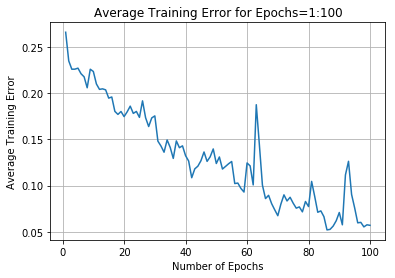

In [12]:
plt.figure()
plt.plot(np.linspace(start=1, stop=num_epochs, num=num_epochs), avg_error_vec)
plt.xlabel("Number of Epochs")
plt.ylabel("Average Training Error")
plt.title("Average Training Error for Epochs=1:100")
plt.grid(True)
# plt.savefig("Neural Net Training Error.jpg")

## Evaluate model on testing set

In [18]:
best_model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    predictions = best_model(samples)
    predictions = torch.flatten(predictions)
    labels = labels.type(torch.DoubleTensor)

    for j in range(0, predictions.size()[0]):
        if predictions[j] < 0.5:
            predictions[j] = 0
        else:
            predictions[j] = 1
    
    error = 1 - torch.sum(predictions == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)
    
model_path = dest_path + "torch_model_4_4_19_lr=" + str(learning_rate) + "_hourly_dict.pt"

Testing set Error: 0.1711


### Save Model

In [14]:
torch.save(model.state_dict(), model_path)

### Load and Evaluate previous models

In [17]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(dest_path + "torch_model_4_4_19_lr=0.001_hourly_dict.pt"))
model.double()     # cast model parameters to double
model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
    for j in range(conf.size()[0]):
        if conf[j] < 0.5:
            conf[j] = 0
        else:
            conf[j] = 1
                
    error = 1 - torch.sum(conf == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)

Testing set Error: 0.1590


## Best Model Evaluation

In [19]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(dest_path + "torch_model_4_4_19_lr=0.001_hourly_dict.pt"))
model.double()     # cast model parameters to double
model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)    # confidence that a certain instance is predicted correctly
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
# convert to numpy arrays
conf = conf.detach().numpy()
labels = labels.numpy()

# sort arrays according to the predicted confidence (high confidence to low confidence)
sort_idx = np.argsort(-conf, kind='mergesort')
conf = conf[sort_idx]
labels = labels[sort_idx]

### ROC Curve

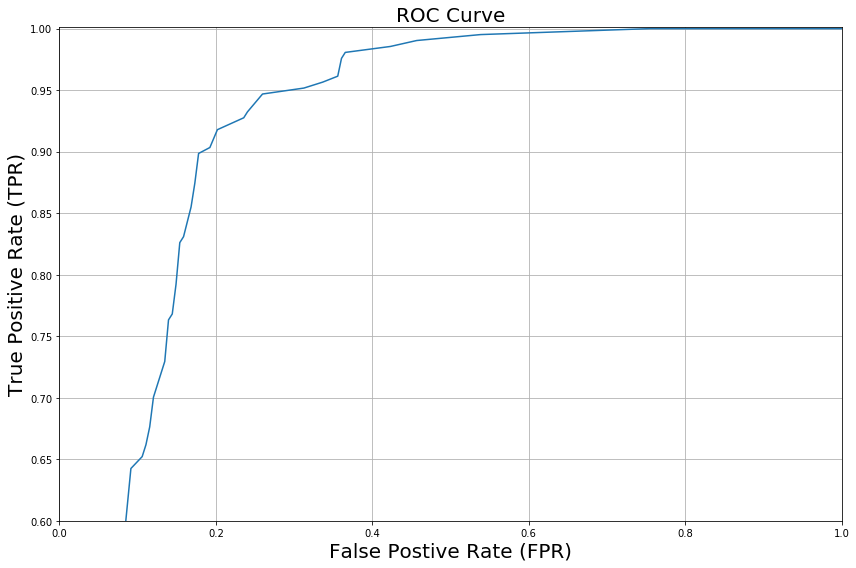

In [20]:
num_pos = 0
num_neg = 0

for label in labels:
    if label < 0.5:
        num_neg += 1
    else:
        num_pos += 1
        
tp = 0
fp = 0
last_tp = 0
fpr = []
tpr = []

for i in range(len(labels)):
    if (i > 1) and (conf[i] != conf[i-1]) and (labels[i] == 0) and (tp > last_tp):
        fpr.append(fp / num_neg)
        tpr.append(tp / num_pos)
        last_tp = tp
    if labels[i] == 1:
        tp += 1
    else:
        fp += 1
        
fpr.append(fp / num_neg)
tpr.append(tp / num_pos)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.xlabel('False Postive Rate (FPR)', fontsize=20)
plt.ylabel('True Positive Rate (TPR)', fontsize=20)
plt.axis([0, 1, 0.6, 1.001])
plt.title('ROC Curve', fontsize=20)
plt.tight_layout()
plt.grid(True)

### PR Curve

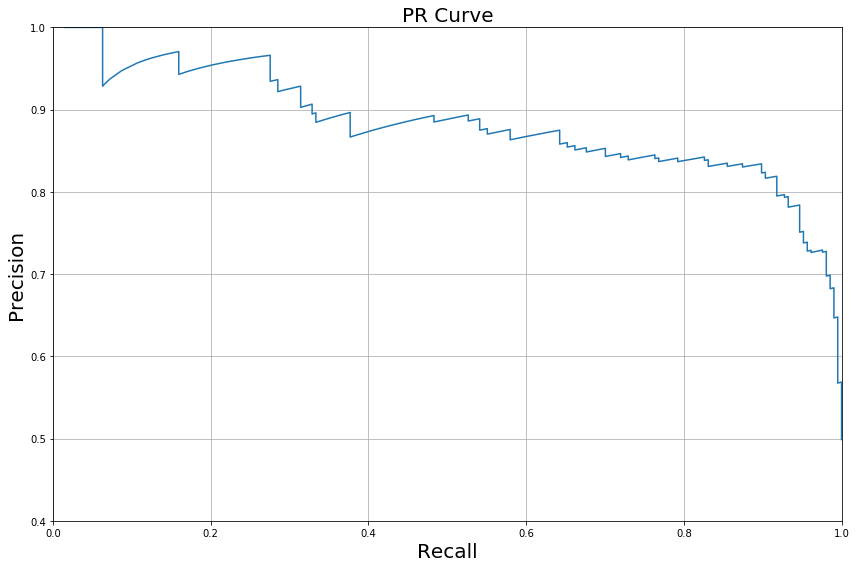

In [21]:
for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    pred = model(samples)
    pred = torch.flatten(pred)
    labels = labels.type(torch.DoubleTensor)

# convert to numpy arrays
pred = pred.detach().numpy()
labels = labels.numpy()

# sort arrays according to the predicted confidence (high confidence to low confidence)
sort_idx = np.argsort(-pred, kind='mergesort')
pred = pred[sort_idx]
labels = labels[sort_idx]

num_pred_pos = 0
num_actual_pos = 0
num_tp = 0
precision = []
recall = []

for confidence in conf:
    for i in range(len(pred)):
        if pred[i] >= confidence:
            num_pred_pos += 1
            
            if labels[i] == 1:
                num_tp += 1
        
        if labels[i] == 1:
            num_actual_pos += 1

    precision.append(num_tp / num_pred_pos)
    recall.append(num_tp / num_actual_pos)
    
    num_pred_pos = 0
    num_actual_pos = 0
    num_tp = 0

plt.figure(figsize=(12, 8))
plt.plot(recall, precision)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.axis([0, 1.001, 0.4, 1])
plt.title('PR Curve', fontsize=20)
plt.tight_layout()
plt.grid(True)

## Test best model on other data sets

### Read in data

In [26]:
# define data path
data_path = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"
data_set = "hourly_data_2014"

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
length_y = len(y)
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (length_y - 1):
        idx = 0

    if y[idx] == 1:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.append(y, y[idx])
            X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
            num_alg += 1
        else:
            idx += 1
    else:
        idx += 1

### Process and split data

In [27]:
# standardize data: remove the mean and variance in each sample
num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y);
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)

# convert numpy arrays to pytorch tensors
train_set_size = X_train.shape
test_set_size = X_test.shape
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=test_set_size[0], shuffle=True)

ValueError: could not convert string to float: '28.95s'

### Evaluate best model

In [ ]:
for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
    for j in range(conf.size()[0]):
        if conf[j] < 0.5:
            conf[j] = 0
        else:
            conf[j] = 1
                
    error = 1 - torch.sum(conf == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)

### Optimizer parameter adjust

In [ ]:
for p in optimizer.param_groups:
    p["lr"] = 0.003
    p["momentum"] = 0.5

In [ ]:
for p in optimizer.param_groups:
    p["lr"] = 0.001
    p["momentum"] = 0.2

In [ ]:
for p in optimizer.param_groups:
    p["lr"] = 0.00001
    p["momentum"] = 0

In [ ]:
for p in optimizer.param_groups:
    p["lr"] = 0.0000005

In [9]:
for p in optimizer.param_groups:
    p["lr"] = 0.0003
    p["momentum"] = 0.5